# Import Libraries

In [2]:
import torch as t
import numpy as np
import torch.nn as nn
import torch.nn.init as init
import torch.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import time
from tqdm import tqdm
from PIL import Image
import seaborn as sns

from torchvision import transforms, datasets, utils

# Dataset

https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

# Constants

In [3]:
test_path = './archive/test'
train_path = './archive/train'
validation_path = './archive/validation'

batch = 64
num_workers = 4
learning_rate = 1e-4
n_epochs = 30
image_size = 224
num_classes = 36
device = t.device("cuda" if t.cuda.is_available() else "cpu")

# Load and preprocess

In [4]:
transform_train = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
])

train_dateset = datasets.ImageFolder(train_path, transform=transform_train)
test_dateset = datasets.ImageFolder(test_path, transform=transform_test)
validation_dateset = datasets.ImageFolder(validation_path, transform=transform_test)

train_loader = t.utils.data.DataLoader(train_dateset, batch_size=batch, shuffle=True, num_workers=num_workers, pin_memory=True)
test_loader = t.utils.data.DataLoader(test_dateset, batch_size=batch, shuffle=True, num_workers=num_workers, pin_memory=True)
validation_loader = t.utils.data.DataLoader(validation_dateset, batch_size=batch, shuffle=True, num_workers=num_workers, pin_memory=True)

print(len(train_loader), len(test_loader), len(validation_loader))

49 6 6


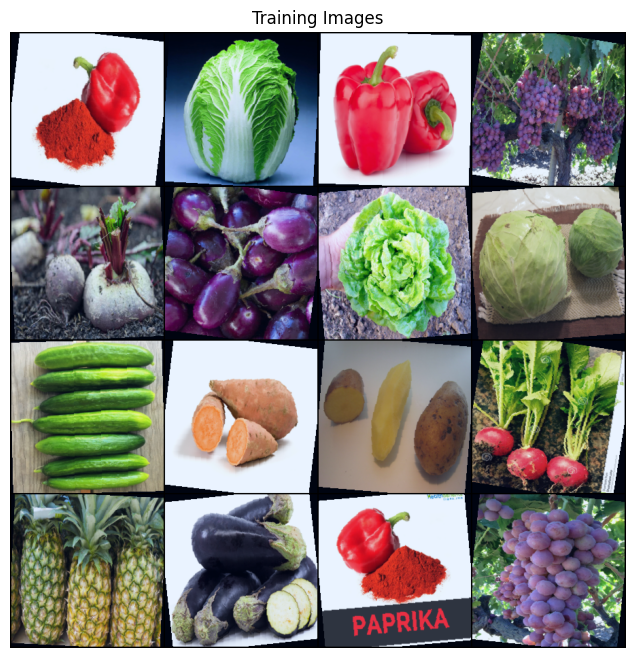

In [5]:
train_loader_iter = iter(train_loader)
images, labels = next(train_loader_iter)
grid = utils.make_grid(images[:16], nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
plt.title('Training Images')
plt.axis('off')
plt.show()

# CNNs

I have choosen the Alex-Net due-to its theoretical and computational simplicity, moreover the Alex-Net is one of the most important architectures, which inspired the more complex solutions. The Alex-Net performs calculations at the fast pace with the robust outcome, which was proven in 2012 during ImageNet tournament.


Source:
Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2017). ImageNet classification with deep convolutional neural networks. Communications of the ACM, 60(6), 84–90. https://doi.org/10.1145/3065386

<center> <h3> Alex-Net: ReLU </h3> </center> 

In [6]:
class AlexNet_ReLU(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

<center> <h3> Alex-Net: Sigmoid </h3> </center>

In [7]:
class AlexNet_Sigmoid(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.Sigmoid(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.Sigmoid(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x
    


<center><h3>Alex-Net: Small Random</h3></center>

In [8]:
class AlexNet_Small_Random(nn.Module):
    def __init__(self, num_classes=36, init_type='small_random') -> None:
        super(AlexNet_Small_Random, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        self.initialize_weights(init_type)
    
    def initialize_weights(self, init_type):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.normal_(m.weight, mean=0.0, std=0.01)
                
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

<center><h3> Alex-Net: Xavier </h3></center>

In [9]:
class AlexNet_Xavier(nn.Module):
    def __init__(self, num_classes=36, init_type='xavier') -> None:
        super(AlexNet_Xavier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        
        self.initialize_weights(init_type)
    
    def initialize_weights(self, init_type):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

<center><h3>Alex-Net: Batch-Normalization</h3></center>

In [10]:
class AlexNet_BatchNorm(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet_BatchNorm, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x


<center><h3>Alex-Net: Leaky ReLU</h3></center>

In [11]:
class AlexNet_LeakyReLU(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.LeakyReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

<center><h3>Alex-Net: ELU</h3></center>

In [12]:
class AlexNet_ELU(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ELU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ELU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

<center><h3>Alex-Net: Kaiming</h3></center>

In [13]:
class AlexNet_Kaiming(nn.Module):
    def __init__(self, num_classes=num_classes) -> None:
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ELU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ELU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ELU(inplace=True),
            nn.Linear(4096, num_classes)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = t.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [14]:
AlexNet_ReLU_Dropout = AlexNet_ReLU(num_classes=num_classes)
AlexNet_Sigmoid = AlexNet_Sigmoid(num_classes=num_classes)
AlexNet_Xavier = AlexNet_Xavier(num_classes=num_classes)
AlexNet_SmallRandom = AlexNet_Small_Random(num_classes=num_classes)
AlexNet_BatchNorm = AlexNet_BatchNorm(num_classes=num_classes)

if t.cuda.is_available():
    device = t.device('cuda')
    AlexNet_ReLU_Dropout = AlexNet_ReLU_Dropout.to(device)
    AlexNet_Sigmoid = AlexNet_Sigmoid.to(device)
    AlexNet_Xavier = AlexNet_Xavier.to(device)
    AlexNet_SmallRandom = AlexNet_SmallRandom.to(device)
    AlexNet_BatchNorm = AlexNet_BatchNorm.to(device)

models = [AlexNet_ReLU_Dropout, AlexNet_Sigmoid, AlexNet_Xavier, AlexNet_SmallRandom, AlexNet_BatchNorm]

In [15]:
AlexNet_LeakyReLU = AlexNet_LeakyReLU(num_classes=num_classes)
AlexNet_ELU = AlexNet_ELU(num_classes=num_classes)
AlexNet_Kaiming = AlexNet_Kaiming(num_classes=num_classes)
AlexNet_L1 = AlexNet_ReLU(num_classes=num_classes)
AlexNet_L2 = AlexNet_ReLU(num_classes=num_classes)

if t.cuda.is_available():
    device = t.device('cuda')
    AlexNet_LeakyReLU = AlexNet_LeakyReLU.to(device)
    AlexNet_ELU = AlexNet_ELU.to(device)
    AlexNet_Kaiming = AlexNet_Kaiming.to(device)
    AlexNet_L1 = AlexNet_L1.to(device)
    AlexNet_L2 = AlexNet_L2.to(device)

models = [AlexNet_LeakyReLU, AlexNet_ELU, AlexNet_Kaiming]
models_L1_L2 = [AlexNet_L1, AlexNet_L2]

# Train CNN

In [15]:
for model in models:
    criteria = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    test_loss_min = np.inf
    start_time = time.time()

    if model.__class__.__name__ + '_model.pt' in os.listdir():
        print(f'{model.__class__.__name__} model found. Skipping training...')
        continue

    with open(model.__class__.__name__ + '_log.txt', 'w') as f:
        f.write(f'AlexNet Model: {model.__class__.__name__}\n')
        f.write(f'Learning Rate: {learning_rate}\n')
        f.write(f'Optimizer: Adam\n')
        f.write(f'Loss function: Cross Entropy\n')
        f.write(f'Batch Size: {batch}\n')
        f.write(f'Number of Epochs: {n_epochs}\n')
        f.write(f'Image Size: {image_size}\n')
        f.write(f'Number of Classes: {num_classes}\n\n')
        for epoch in range(n_epochs):
            model.train()
            train_loss = 0
            correct = 0
            
            with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{n_epochs}', unit='batch') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    output = model(data)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    
                    train_loss += loss.item() * data.size(0)
                    _, predicted = output.max(1)
                    correct += predicted.eq(target).sum().item()
                    
                    pbar.update(1)
                    pbar.set_postfix({'loss': loss.item()})
            
            train_loss /= len(train_loader.dataset)
            train_accuracy = 100. * correct / len(train_loader.dataset)
            


            test_loss = 0
            correct = 0
            model.eval()
            with t.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criteria(output, target)
                    test_loss += loss.item() * data.size(0)
                    _, predicted = output.max(1)
                    correct += predicted.eq(target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_accuracy = 100. * correct / len(test_loader.dataset)
            
            print(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Training Acc: {train_accuracy:.2f}%, Testing Loss: {test_loss:.6f}, Testing Acc: {test_accuracy:.2f}%')
            
            f.write(f'Epoch: {epoch + 1}, Training Loss: {train_loss:.6f}, Training Acc: {train_accuracy:.2f}%, Testing Loss: {test_loss:.6f}, Testing Acc: {test_accuracy:.2f}%\n')

            if test_loss < test_loss_min:
                print(f'Test loss decreased ({test_loss_min:.6f} --> {test_loss:.6f}). Saving model...')
                t.save(model.state_dict(), model.__class__.__name__ + '_model.pt')
                test_loss_min = test_loss


            time_elapsed = time.time() - start_time
            estimated_time = (time_elapsed / (epoch + 1)) * (n_epochs - (epoch + 1))
            print(f'Time Elapsed: {int(time_elapsed // 60)}m {int(time_elapsed % 60)}s')
            print(f'Estimated Time Remaining: {int(estimated_time // 60)}m {int(estimated_time % 60)}s')

        print('Training completed.')


Epoch 1/30: 100%|██████████| 49/49 [00:41<00:00,  1.18batch/s, loss=3.2] 


Epoch: 1, Training Loss: 3.480502, Training Acc: 4.27%, Testing Loss: 3.166711, Testing Acc: 6.41%
Test loss decreased (inf --> 3.166711). Saving model...
Time Elapsed: 0m 50s
Estimated Time Remaining: 24m 36s


Epoch 2/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=2.76]


Epoch: 2, Training Loss: 2.983394, Training Acc: 12.58%, Testing Loss: 2.563258, Testing Acc: 18.38%
Test loss decreased (3.166711 --> 2.563258). Saving model...
Time Elapsed: 1m 38s
Estimated Time Remaining: 22m 58s


Epoch 3/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=2.63]


Epoch: 3, Training Loss: 2.706950, Training Acc: 17.62%, Testing Loss: 2.256381, Testing Acc: 27.30%
Test loss decreased (2.563258 --> 2.256381). Saving model...
Time Elapsed: 2m 26s
Estimated Time Remaining: 21m 58s


Epoch 4/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=2.54]


Epoch: 4, Training Loss: 2.432428, Training Acc: 25.07%, Testing Loss: 2.008745, Testing Acc: 35.10%
Test loss decreased (2.256381 --> 2.008745). Saving model...
Time Elapsed: 3m 14s
Estimated Time Remaining: 21m 1s


Epoch 5/30: 100%|██████████| 49/49 [00:39<00:00,  1.26batch/s, loss=2.22]


Epoch: 5, Training Loss: 2.364889, Training Acc: 27.32%, Testing Loss: 1.797658, Testing Acc: 40.95%
Test loss decreased (2.008745 --> 1.797658). Saving model...
Time Elapsed: 4m 9s
Estimated Time Remaining: 20m 45s


Epoch 6/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=2.15]


Epoch: 6, Training Loss: 2.194778, Training Acc: 31.40%, Testing Loss: 1.718133, Testing Acc: 44.57%
Test loss decreased (1.797658 --> 1.718133). Saving model...
Time Elapsed: 4m 57s
Estimated Time Remaining: 19m 50s


Epoch 7/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=2.14]


Epoch: 7, Training Loss: 2.067770, Training Acc: 35.28%, Testing Loss: 1.503818, Testing Acc: 49.86%
Test loss decreased (1.718133 --> 1.503818). Saving model...
Time Elapsed: 5m 45s
Estimated Time Remaining: 18m 55s


Epoch 8/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.93]


Epoch: 8, Training Loss: 2.011340, Training Acc: 35.99%, Testing Loss: 1.398239, Testing Acc: 55.15%
Test loss decreased (1.503818 --> 1.398239). Saving model...
Time Elapsed: 6m 33s
Estimated Time Remaining: 18m 1s


Epoch 9/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=2.09]


Epoch: 9, Training Loss: 1.906038, Training Acc: 39.71%, Testing Loss: 1.353249, Testing Acc: 56.27%
Test loss decreased (1.398239 --> 1.353249). Saving model...
Time Elapsed: 7m 21s
Estimated Time Remaining: 17m 9s


Epoch 10/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.8] 


Epoch: 10, Training Loss: 1.876131, Training Acc: 41.03%, Testing Loss: 1.364298, Testing Acc: 59.33%
Time Elapsed: 8m 8s
Estimated Time Remaining: 16m 16s


Epoch 11/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.49]


Epoch: 11, Training Loss: 1.764954, Training Acc: 44.46%, Testing Loss: 1.152589, Testing Acc: 63.79%
Test loss decreased (1.353249 --> 1.152589). Saving model...
Time Elapsed: 8m 55s
Estimated Time Remaining: 15m 25s


Epoch 12/30: 100%|██████████| 49/49 [00:39<00:00,  1.23batch/s, loss=1.53]


Epoch: 12, Training Loss: 1.711786, Training Acc: 46.10%, Testing Loss: 1.125026, Testing Acc: 66.30%
Test loss decreased (1.152589 --> 1.125026). Saving model...
Time Elapsed: 9m 43s
Estimated Time Remaining: 14m 35s


Epoch 13/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=1.53]


Epoch: 13, Training Loss: 1.609636, Training Acc: 48.64%, Testing Loss: 1.095620, Testing Acc: 65.74%
Test loss decreased (1.125026 --> 1.095620). Saving model...
Time Elapsed: 10m 30s
Estimated Time Remaining: 13m 44s


Epoch 14/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=1.64]


Epoch: 14, Training Loss: 1.506181, Training Acc: 52.23%, Testing Loss: 0.951816, Testing Acc: 71.59%
Test loss decreased (1.095620 --> 0.951816). Saving model...
Time Elapsed: 11m 17s
Estimated Time Remaining: 12m 54s


Epoch 15/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.27]


Epoch: 15, Training Loss: 1.471985, Training Acc: 52.87%, Testing Loss: 0.883998, Testing Acc: 74.09%
Test loss decreased (0.951816 --> 0.883998). Saving model...
Time Elapsed: 12m 5s
Estimated Time Remaining: 12m 5s


Epoch 16/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.38]


Epoch: 16, Training Loss: 1.358496, Training Acc: 57.34%, Testing Loss: 0.820212, Testing Acc: 76.04%
Test loss decreased (0.883998 --> 0.820212). Saving model...
Time Elapsed: 12m 52s
Estimated Time Remaining: 11m 16s


Epoch 17/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=1.31] 


Epoch: 17, Training Loss: 1.308044, Training Acc: 57.88%, Testing Loss: 0.660051, Testing Acc: 81.06%
Test loss decreased (0.820212 --> 0.660051). Saving model...
Time Elapsed: 13m 40s
Estimated Time Remaining: 10m 27s


Epoch 18/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.37] 


Epoch: 18, Training Loss: 1.190115, Training Acc: 61.73%, Testing Loss: 0.642677, Testing Acc: 83.01%
Test loss decreased (0.660051 --> 0.642677). Saving model...
Time Elapsed: 14m 27s
Estimated Time Remaining: 9m 38s


Epoch 19/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.525]


Epoch: 19, Training Loss: 1.099614, Training Acc: 63.15%, Testing Loss: 0.568884, Testing Acc: 84.96%
Test loss decreased (0.642677 --> 0.568884). Saving model...
Time Elapsed: 15m 14s
Estimated Time Remaining: 8m 49s


Epoch 20/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=1.19] 


Epoch: 20, Training Loss: 1.069622, Training Acc: 65.04%, Testing Loss: 0.547913, Testing Acc: 83.57%
Test loss decreased (0.568884 --> 0.547913). Saving model...
Time Elapsed: 16m 2s
Estimated Time Remaining: 8m 1s


Epoch 21/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=1.07] 


Epoch: 21, Training Loss: 0.965496, Training Acc: 68.15%, Testing Loss: 0.507598, Testing Acc: 85.52%
Test loss decreased (0.547913 --> 0.507598). Saving model...
Time Elapsed: 16m 49s
Estimated Time Remaining: 7m 12s


Epoch 22/30: 100%|██████████| 49/49 [00:39<00:00,  1.23batch/s, loss=1.1]  


Epoch: 22, Training Loss: 0.903225, Training Acc: 69.79%, Testing Loss: 0.485180, Testing Acc: 87.47%
Test loss decreased (0.507598 --> 0.485180). Saving model...
Time Elapsed: 17m 38s
Estimated Time Remaining: 6m 24s


Epoch 23/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.869]


Epoch: 23, Training Loss: 0.839025, Training Acc: 72.39%, Testing Loss: 0.450977, Testing Acc: 87.19%
Test loss decreased (0.485180 --> 0.450977). Saving model...
Time Elapsed: 18m 25s
Estimated Time Remaining: 5m 36s


Epoch 24/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.871]


Epoch: 24, Training Loss: 0.744061, Training Acc: 74.99%, Testing Loss: 0.385219, Testing Acc: 89.69%
Test loss decreased (0.450977 --> 0.385219). Saving model...
Time Elapsed: 19m 12s
Estimated Time Remaining: 4m 48s


Epoch 25/30: 100%|██████████| 49/49 [00:39<00:00,  1.25batch/s, loss=0.892]


Epoch: 25, Training Loss: 0.716292, Training Acc: 75.89%, Testing Loss: 0.374869, Testing Acc: 89.97%
Test loss decreased (0.385219 --> 0.374869). Saving model...
Time Elapsed: 20m 0s
Estimated Time Remaining: 4m 0s


Epoch 26/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.451]


Epoch: 26, Training Loss: 0.637924, Training Acc: 78.72%, Testing Loss: 0.371851, Testing Acc: 89.69%
Test loss decreased (0.374869 --> 0.371851). Saving model...
Time Elapsed: 20m 47s
Estimated Time Remaining: 3m 11s


Epoch 27/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.48] 


Epoch: 27, Training Loss: 0.626392, Training Acc: 78.97%, Testing Loss: 0.333844, Testing Acc: 92.20%
Test loss decreased (0.371851 --> 0.333844). Saving model...
Time Elapsed: 21m 34s
Estimated Time Remaining: 2m 23s


Epoch 28/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.627]


Epoch: 28, Training Loss: 0.543714, Training Acc: 81.77%, Testing Loss: 0.321913, Testing Acc: 90.81%
Test loss decreased (0.333844 --> 0.321913). Saving model...
Time Elapsed: 22m 21s
Estimated Time Remaining: 1m 35s


Epoch 29/30: 100%|██████████| 49/49 [00:39<00:00,  1.24batch/s, loss=0.513]


Epoch: 29, Training Loss: 0.565913, Training Acc: 81.48%, Testing Loss: 0.318925, Testing Acc: 93.04%
Test loss decreased (0.321913 --> 0.318925). Saving model...
Time Elapsed: 23m 10s
Estimated Time Remaining: 0m 47s


Epoch 30/30: 100%|██████████| 49/49 [00:38<00:00,  1.26batch/s, loss=0.371]


Epoch: 30, Training Loss: 0.461743, Training Acc: 84.30%, Testing Loss: 0.329177, Testing Acc: 92.20%
Time Elapsed: 23m 56s
Estimated Time Remaining: 0m 0s
Training completed.


Epoch 1/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=2.76]


Epoch: 1, Training Loss: 3.037935, Training Acc: 13.19%, Testing Loss: 2.287349, Testing Acc: 33.43%
Test loss decreased (inf --> 2.287349). Saving model...
Time Elapsed: 1m 10s
Estimated Time Remaining: 34m 4s


Epoch 2/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=2.23]


Epoch: 2, Training Loss: 2.457153, Training Acc: 28.67%, Testing Loss: 1.867670, Testing Acc: 42.90%
Test loss decreased (2.287349 --> 1.867670). Saving model...
Time Elapsed: 2m 20s
Estimated Time Remaining: 32m 52s


Epoch 3/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=2.24]


Epoch: 3, Training Loss: 2.212904, Training Acc: 34.06%, Testing Loss: 1.713660, Testing Acc: 48.19%
Test loss decreased (1.867670 --> 1.713660). Saving model...
Time Elapsed: 3m 31s
Estimated Time Remaining: 31m 39s


Epoch 4/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=1.81]


Epoch: 4, Training Loss: 2.022192, Training Acc: 40.55%, Testing Loss: 1.357009, Testing Acc: 56.82%
Test loss decreased (1.713660 --> 1.357009). Saving model...
Time Elapsed: 4m 40s
Estimated Time Remaining: 30m 25s


Epoch 5/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.74]


Epoch: 5, Training Loss: 1.912046, Training Acc: 42.47%, Testing Loss: 1.331784, Testing Acc: 59.89%
Test loss decreased (1.357009 --> 1.331784). Saving model...
Time Elapsed: 5m 52s
Estimated Time Remaining: 29m 20s


Epoch 6/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.98]


Epoch: 6, Training Loss: 1.761274, Training Acc: 46.26%, Testing Loss: 1.224844, Testing Acc: 61.56%
Test loss decreased (1.331784 --> 1.224844). Saving model...
Time Elapsed: 7m 2s
Estimated Time Remaining: 28m 8s


Epoch 7/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.96]


Epoch: 7, Training Loss: 1.674966, Training Acc: 48.76%, Testing Loss: 1.027691, Testing Acc: 69.36%
Test loss decreased (1.224844 --> 1.027691). Saving model...
Time Elapsed: 8m 12s
Estimated Time Remaining: 26m 56s


Epoch 8/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=1.69]


Epoch: 8, Training Loss: 1.576916, Training Acc: 51.40%, Testing Loss: 0.869228, Testing Acc: 74.37%
Test loss decreased (1.027691 --> 0.869228). Saving model...
Time Elapsed: 9m 22s
Estimated Time Remaining: 25m 47s


Epoch 9/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=1.61]


Epoch: 9, Training Loss: 1.432421, Training Acc: 56.53%, Testing Loss: 0.800058, Testing Acc: 78.27%
Test loss decreased (0.869228 --> 0.800058). Saving model...
Time Elapsed: 10m 34s
Estimated Time Remaining: 24m 39s


Epoch 10/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.82] 


Epoch: 10, Training Loss: 1.380999, Training Acc: 57.43%, Testing Loss: 0.826900, Testing Acc: 76.60%
Time Elapsed: 11m 44s
Estimated Time Remaining: 23m 29s


Epoch 11/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.29] 


Epoch: 11, Training Loss: 1.293962, Training Acc: 59.58%, Testing Loss: 0.746752, Testing Acc: 78.83%
Test loss decreased (0.800058 --> 0.746752). Saving model...
Time Elapsed: 12m 54s
Estimated Time Remaining: 22m 18s


Epoch 12/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.03] 


Epoch: 12, Training Loss: 1.131219, Training Acc: 64.43%, Testing Loss: 0.658528, Testing Acc: 82.73%
Test loss decreased (0.746752 --> 0.658528). Saving model...
Time Elapsed: 14m 4s
Estimated Time Remaining: 21m 6s


Epoch 13/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=1.03] 


Epoch: 13, Training Loss: 1.102250, Training Acc: 65.81%, Testing Loss: 0.620958, Testing Acc: 83.01%
Test loss decreased (0.658528 --> 0.620958). Saving model...
Time Elapsed: 15m 15s
Estimated Time Remaining: 19m 57s


Epoch 14/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.924]


Epoch: 14, Training Loss: 1.018865, Training Acc: 67.54%, Testing Loss: 0.449678, Testing Acc: 89.14%
Test loss decreased (0.620958 --> 0.449678). Saving model...
Time Elapsed: 16m 26s
Estimated Time Remaining: 18m 47s


Epoch 15/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=1.04] 


Epoch: 15, Training Loss: 0.936431, Training Acc: 70.56%, Testing Loss: 0.447632, Testing Acc: 89.14%
Test loss decreased (0.449678 --> 0.447632). Saving model...
Time Elapsed: 17m 37s
Estimated Time Remaining: 17m 37s


Epoch 16/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.921]


Epoch: 16, Training Loss: 0.888038, Training Acc: 71.49%, Testing Loss: 0.411822, Testing Acc: 88.30%
Test loss decreased (0.447632 --> 0.411822). Saving model...
Time Elapsed: 18m 47s
Estimated Time Remaining: 16m 26s


Epoch 17/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.697]


Epoch: 17, Training Loss: 0.804570, Training Acc: 74.38%, Testing Loss: 0.332672, Testing Acc: 90.53%
Test loss decreased (0.411822 --> 0.332672). Saving model...
Time Elapsed: 19m 58s
Estimated Time Remaining: 15m 16s


Epoch 18/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.686]


Epoch: 18, Training Loss: 0.715460, Training Acc: 77.17%, Testing Loss: 0.359982, Testing Acc: 90.53%
Time Elapsed: 21m 9s
Estimated Time Remaining: 14m 6s


Epoch 19/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.368]


Epoch: 19, Training Loss: 0.646537, Training Acc: 78.88%, Testing Loss: 0.336778, Testing Acc: 92.20%
Time Elapsed: 22m 19s
Estimated Time Remaining: 12m 55s


Epoch 20/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.603]


Epoch: 20, Training Loss: 0.574083, Training Acc: 80.96%, Testing Loss: 0.336713, Testing Acc: 91.09%
Time Elapsed: 23m 29s
Estimated Time Remaining: 11m 44s


Epoch 21/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.6]  


Epoch: 21, Training Loss: 0.586602, Training Acc: 80.61%, Testing Loss: 0.378806, Testing Acc: 90.53%
Time Elapsed: 24m 39s
Estimated Time Remaining: 10m 34s


Epoch 22/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=0.473]


Epoch: 22, Training Loss: 0.515056, Training Acc: 82.22%, Testing Loss: 0.242902, Testing Acc: 93.59%
Test loss decreased (0.332672 --> 0.242902). Saving model...
Time Elapsed: 25m 50s
Estimated Time Remaining: 9m 23s


Epoch 23/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.464]


Epoch: 23, Training Loss: 0.462011, Training Acc: 84.27%, Testing Loss: 0.235009, Testing Acc: 94.99%
Test loss decreased (0.242902 --> 0.235009). Saving model...
Time Elapsed: 27m 0s
Estimated Time Remaining: 8m 13s


Epoch 24/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=0.528]


Epoch: 24, Training Loss: 0.371429, Training Acc: 87.51%, Testing Loss: 0.287412, Testing Acc: 93.04%
Time Elapsed: 28m 11s
Estimated Time Remaining: 7m 2s


Epoch 25/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.243]


Epoch: 25, Training Loss: 0.382158, Training Acc: 87.13%, Testing Loss: 0.302735, Testing Acc: 92.48%
Time Elapsed: 29m 21s
Estimated Time Remaining: 5m 52s


Epoch 26/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.38] 


Epoch: 26, Training Loss: 0.356442, Training Acc: 88.31%, Testing Loss: 0.246386, Testing Acc: 94.43%
Time Elapsed: 30m 33s
Estimated Time Remaining: 4m 42s


Epoch 27/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.206]


Epoch: 27, Training Loss: 0.306794, Training Acc: 89.89%, Testing Loss: 0.301150, Testing Acc: 94.15%
Time Elapsed: 31m 43s
Estimated Time Remaining: 3m 31s


Epoch 28/30: 100%|██████████| 49/49 [01:02<00:00,  1.27s/batch, loss=0.549]


Epoch: 28, Training Loss: 0.284605, Training Acc: 89.95%, Testing Loss: 0.264649, Testing Acc: 93.87%
Time Elapsed: 32m 54s
Estimated Time Remaining: 2m 21s


Epoch 29/30: 100%|██████████| 49/49 [01:02<00:00,  1.28s/batch, loss=0.251]


Epoch: 29, Training Loss: 0.294251, Training Acc: 90.18%, Testing Loss: 0.280429, Testing Acc: 94.15%
Time Elapsed: 34m 4s
Estimated Time Remaining: 1m 10s


Epoch 30/30: 100%|██████████| 49/49 [01:01<00:00,  1.26s/batch, loss=0.522] 


Epoch: 30, Training Loss: 0.260382, Training Acc: 91.49%, Testing Loss: 0.241574, Testing Acc: 95.82%
Time Elapsed: 35m 14s
Estimated Time Remaining: 0m 0s
Training completed.


Epoch 1/30: 100%|██████████| 49/49 [01:36<00:00,  1.97s/batch, loss=19]  


Epoch: 1, Training Loss: 32.126055, Training Acc: 9.60%, Testing Loss: 10.143207, Testing Acc: 26.46%
Test loss decreased (inf --> 10.143207). Saving model...
Time Elapsed: 1m 44s
Estimated Time Remaining: 50m 39s


Epoch 2/30: 100%|██████████| 49/49 [01:39<00:00,  2.03s/batch, loss=17.1]


Epoch: 2, Training Loss: 17.272226, Training Acc: 15.92%, Testing Loss: 7.339447, Testing Acc: 36.49%
Test loss decreased (10.143207 --> 7.339447). Saving model...
Time Elapsed: 3m 33s
Estimated Time Remaining: 49m 43s


Epoch 3/30: 100%|██████████| 49/49 [01:35<00:00,  1.95s/batch, loss=15]  


Epoch: 3, Training Loss: 14.790252, Training Acc: 19.10%, Testing Loss: 7.884107, Testing Acc: 38.72%
Time Elapsed: 5m 16s
Estimated Time Remaining: 47m 32s


Epoch 4/30: 100%|██████████| 49/49 [01:36<00:00,  1.96s/batch, loss=11]  


Epoch: 4, Training Loss: 13.027470, Training Acc: 22.54%, Testing Loss: 4.382615, Testing Acc: 51.81%
Test loss decreased (7.339447 --> 4.382615). Saving model...
Time Elapsed: 7m 1s
Estimated Time Remaining: 45m 38s


Epoch 5/30: 100%|██████████| 49/49 [01:35<00:00,  1.95s/batch, loss=11.8]


Epoch: 5, Training Loss: 11.520164, Training Acc: 25.23%, Testing Loss: 5.832035, Testing Acc: 47.91%
Time Elapsed: 8m 45s
Estimated Time Remaining: 43m 47s


Epoch 6/30: 100%|██████████| 49/49 [01:35<00:00,  1.95s/batch, loss=10.9]


Epoch: 6, Training Loss: 11.337749, Training Acc: 27.26%, Testing Loss: 3.359400, Testing Acc: 57.38%
Test loss decreased (4.382615 --> 3.359400). Saving model...
Time Elapsed: 10m 29s
Estimated Time Remaining: 41m 56s


Epoch 7/30: 100%|██████████| 49/49 [01:35<00:00,  1.95s/batch, loss=12.7]


Epoch: 7, Training Loss: 10.267958, Training Acc: 28.22%, Testing Loss: 3.474941, Testing Acc: 59.05%
Time Elapsed: 12m 12s
Estimated Time Remaining: 40m 7s


Epoch 8/30: 100%|██████████| 49/49 [01:56<00:00,  2.38s/batch, loss=11.7]


Epoch: 8, Training Loss: 9.493894, Training Acc: 29.92%, Testing Loss: 4.054415, Testing Acc: 56.27%
Time Elapsed: 14m 17s
Estimated Time Remaining: 39m 17s


Epoch 9/30: 100%|██████████| 49/49 [01:47<00:00,  2.19s/batch, loss=11.4]


Epoch: 9, Training Loss: 9.470102, Training Acc: 30.56%, Testing Loss: 3.294228, Testing Acc: 59.89%
Test loss decreased (3.359400 --> 3.294228). Saving model...
Time Elapsed: 16m 12s
Estimated Time Remaining: 37m 48s


Epoch 10/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=7.91]


Epoch: 10, Training Loss: 8.569559, Training Acc: 31.88%, Testing Loss: 3.502926, Testing Acc: 57.66%
Time Elapsed: 18m 6s
Estimated Time Remaining: 36m 12s


Epoch 11/30: 100%|██████████| 49/49 [01:45<00:00,  2.15s/batch, loss=6.4] 


Epoch: 11, Training Loss: 8.351587, Training Acc: 32.78%, Testing Loss: 2.691975, Testing Acc: 65.18%
Test loss decreased (3.294228 --> 2.691975). Saving model...
Time Elapsed: 19m 59s
Estimated Time Remaining: 34m 31s


Epoch 12/30: 100%|██████████| 49/49 [01:45<00:00,  2.15s/batch, loss=7.71]


Epoch: 12, Training Loss: 7.799388, Training Acc: 35.41%, Testing Loss: 3.165429, Testing Acc: 60.17%
Time Elapsed: 21m 53s
Estimated Time Remaining: 32m 49s


Epoch 13/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=6.9] 


Epoch: 13, Training Loss: 7.653211, Training Acc: 35.09%, Testing Loss: 2.519823, Testing Acc: 62.95%
Test loss decreased (2.691975 --> 2.519823). Saving model...
Time Elapsed: 23m 46s
Estimated Time Remaining: 31m 5s


Epoch 14/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=7.19]


Epoch: 14, Training Loss: 7.166877, Training Acc: 37.62%, Testing Loss: 2.585318, Testing Acc: 65.74%
Time Elapsed: 25m 40s
Estimated Time Remaining: 29m 21s


Epoch 15/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=8.57]


Epoch: 15, Training Loss: 7.087189, Training Acc: 37.78%, Testing Loss: 2.220345, Testing Acc: 72.98%
Test loss decreased (2.519823 --> 2.220345). Saving model...
Time Elapsed: 27m 35s
Estimated Time Remaining: 27m 35s


Epoch 16/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=5.8] 


Epoch: 16, Training Loss: 6.846112, Training Acc: 38.88%, Testing Loss: 1.805750, Testing Acc: 70.47%
Test loss decreased (2.220345 --> 1.805750). Saving model...
Time Elapsed: 29m 30s
Estimated Time Remaining: 25m 48s


Epoch 17/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=6.73]


Epoch: 17, Training Loss: 6.719061, Training Acc: 40.61%, Testing Loss: 1.503651, Testing Acc: 77.16%
Test loss decreased (1.805750 --> 1.503651). Saving model...
Time Elapsed: 31m 24s
Estimated Time Remaining: 24m 0s


Epoch 18/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=4.76]


Epoch: 18, Training Loss: 6.450714, Training Acc: 40.74%, Testing Loss: 1.694787, Testing Acc: 78.27%
Time Elapsed: 33m 18s
Estimated Time Remaining: 22m 12s


Epoch 19/30: 100%|██████████| 49/49 [01:46<00:00,  2.17s/batch, loss=6.63]


Epoch: 19, Training Loss: 6.384615, Training Acc: 42.50%, Testing Loss: 2.364506, Testing Acc: 70.75%
Time Elapsed: 35m 12s
Estimated Time Remaining: 20m 23s


Epoch 20/30: 100%|██████████| 49/49 [01:46<00:00,  2.16s/batch, loss=6.66]


Epoch: 20, Training Loss: 6.078790, Training Acc: 42.60%, Testing Loss: 1.687482, Testing Acc: 76.32%
Time Elapsed: 37m 6s
Estimated Time Remaining: 18m 33s


Epoch 21/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=4.75]


Epoch: 21, Training Loss: 5.992548, Training Acc: 44.43%, Testing Loss: 1.516903, Testing Acc: 77.99%
Time Elapsed: 38m 59s
Estimated Time Remaining: 16m 42s


Epoch 22/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=10.2]


Epoch: 22, Training Loss: 5.692613, Training Acc: 44.30%, Testing Loss: 1.854673, Testing Acc: 75.77%
Time Elapsed: 40m 53s
Estimated Time Remaining: 14m 52s


Epoch 23/30: 100%|██████████| 49/49 [01:45<00:00,  2.15s/batch, loss=5.36]


Epoch: 23, Training Loss: 5.803775, Training Acc: 45.94%, Testing Loss: 1.335719, Testing Acc: 82.73%
Test loss decreased (1.503651 --> 1.335719). Saving model...
Time Elapsed: 42m 47s
Estimated Time Remaining: 13m 1s


Epoch 24/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=6.6] 


Epoch: 24, Training Loss: 5.804628, Training Acc: 46.55%, Testing Loss: 1.612521, Testing Acc: 77.44%
Time Elapsed: 44m 41s
Estimated Time Remaining: 11m 10s


Epoch 25/30: 100%|██████████| 49/49 [01:45<00:00,  2.15s/batch, loss=5.48]


Epoch: 25, Training Loss: 5.298726, Training Acc: 48.19%, Testing Loss: 1.442887, Testing Acc: 80.50%
Time Elapsed: 46m 35s
Estimated Time Remaining: 9m 19s


Epoch 26/30: 100%|██████████| 49/49 [01:45<00:00,  2.16s/batch, loss=4.96]


Epoch: 26, Training Loss: 5.185000, Training Acc: 49.66%, Testing Loss: 1.545054, Testing Acc: 79.11%
Time Elapsed: 48m 28s
Estimated Time Remaining: 7m 27s


Epoch 27/30: 100%|██████████| 49/49 [02:09<00:00,  2.64s/batch, loss=5.59]


Epoch: 27, Training Loss: 4.961197, Training Acc: 50.40%, Testing Loss: 1.735240, Testing Acc: 78.83%
Time Elapsed: 50m 46s
Estimated Time Remaining: 5m 38s


Epoch 28/30: 100%|██████████| 49/49 [01:50<00:00,  2.26s/batch, loss=4.19]


Epoch: 28, Training Loss: 5.174550, Training Acc: 50.72%, Testing Loss: 1.406403, Testing Acc: 81.34%
Time Elapsed: 52m 44s
Estimated Time Remaining: 3m 46s


Epoch 29/30: 100%|██████████| 49/49 [01:49<00:00,  2.23s/batch, loss=4.48]


Epoch: 29, Training Loss: 4.723637, Training Acc: 53.23%, Testing Loss: 1.472677, Testing Acc: 79.67%
Time Elapsed: 54m 41s
Estimated Time Remaining: 1m 53s


Epoch 30/30: 100%|██████████| 49/49 [01:52<00:00,  2.30s/batch, loss=4.3] 


Epoch: 30, Training Loss: 4.718399, Training Acc: 53.39%, Testing Loss: 1.697362, Testing Acc: 80.22%
Time Elapsed: 56m 42s
Estimated Time Remaining: 0m 0s
Training completed.


### Training with L1 and L2

In [ ]:
l1_lambda = 0.0005
l2_lambda = 1e-4

for i in range(2):
    model = models_L1_L2[i]
    
    criteria = nn.CrossEntropyLoss()

    if i == 1:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)
    else:
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    test_loss_min = np.inf
    start_time = time.time()

    model_name = model.__class__.__name__ + ('_L1' if i == 0 else '_L2')

    if model_name + '_model.pt' in os.listdir():
        print(f'{model_name} model found. Skipping training...')
        continue

    with open(model_name + '_log.txt', 'w') as f:
        f.write(f'Model: {model_name}\n')
        f.write(f'Learning Rate: {learning_rate}\n')
        f.write(f'Optimizer: Adam\n')
        f.write(f'Loss function: Cross Entropy\n')
        f.write(f'Number of Epochs: {n_epochs}\n')
        f.write(f'Regularization: {"L1" if model_name == "AlexNet_L1" else "L2"}\n\n')

        for epoch in range(n_epochs):
            model.train()
            train_loss = 0
            correct = 0
            
            with tqdm(total=len(train_loader), desc=f'{model_name} Epoch {epoch+1}/{n_epochs}', unit='batch') as pbar:
                for batch_idx, (data, target) in enumerate(train_loader):
                    data, target = data.to(device), target.to(device)
                    optimizer.zero_grad()
                    
                    output = model(data)
                    loss = criteria(output, target)

                    if model_name == 'AlexNet_ReLU_L1':
                        l1_loss = sum(p.abs().sum() for p in model.parameters())
                        total_loss = loss + l1_lambda * l1_loss
                    else:
                        total_loss = loss

                    total_loss.backward()
                    optimizer.step()
                    
                    train_loss += total_loss.item() * data.size(0)
                    _, predicted = output.max(1)
                    correct += predicted.eq(target).sum().item()
                    
                    pbar.update(1)
                    pbar.set_postfix({'loss': total_loss.item()})
            
            train_loss /= len(train_loader.dataset)
            train_accuracy = 100. * correct / len(train_loader.dataset)
            
            test_loss = 0
            correct = 0
            model.eval()
            with t.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criteria(output, target)
                    test_loss += loss.item() * data.size(0)
                    _, predicted = output.max(1)
                    correct += predicted.eq(target).sum().item()
                    
            test_loss /= len(test_loader.dataset)
            test_accuracy = 100. * correct / len(test_loader.dataset)
            
            f.write(f'Epoch {epoch+1}/{n_epochs}\n')
            f.write(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%\n')
            f.write(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%\n\n')
            
            if test_loss <= test_loss_min:
                print(f'Saving {model_name} model (epoch {epoch+1}) with test loss {test_loss:.4f}')
                t.save(model.state_dict(), model_name + '_model.pt')
                test_loss_min = test_loss


AlexNet_ReLU_L1 model found. Skipping training...


AlexNet_ReLU_L2 Epoch 1/30:   0%|          | 0/49 [00:00<?, ?batch/s]

AlexNet_ReLU_L2 Epoch 1/30: 100%|██████████| 49/49 [00:42<00:00,  1.14batch/s, loss=3.29]


Saving AlexNet_ReLU_L2 model (epoch 1) with test loss 3.2790


AlexNet_ReLU_L2 Epoch 2/30: 100%|██████████| 49/49 [00:33<00:00,  1.44batch/s, loss=3.3] 


Saving AlexNet_ReLU_L2 model (epoch 2) with test loss 3.0431


AlexNet_ReLU_L2 Epoch 3/30: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=2.72]


Saving AlexNet_ReLU_L2 model (epoch 3) with test loss 2.5591


AlexNet_ReLU_L2 Epoch 4/30: 100%|██████████| 49/49 [00:35<00:00,  1.40batch/s, loss=2.36]


Saving AlexNet_ReLU_L2 model (epoch 4) with test loss 2.1457


AlexNet_ReLU_L2 Epoch 5/30: 100%|██████████| 49/49 [00:34<00:00,  1.41batch/s, loss=2.23]


Saving AlexNet_ReLU_L2 model (epoch 5) with test loss 1.9413


AlexNet_ReLU_L2 Epoch 6/30: 100%|██████████| 49/49 [00:35<00:00,  1.39batch/s, loss=2.17]


Saving AlexNet_ReLU_L2 model (epoch 6) with test loss 1.7770


AlexNet_ReLU_L2 Epoch 7/30: 100%|██████████| 49/49 [00:36<00:00,  1.36batch/s, loss=1.94]


Saving AlexNet_ReLU_L2 model (epoch 7) with test loss 1.6481


AlexNet_ReLU_L2 Epoch 8/30: 100%|██████████| 49/49 [00:35<00:00,  1.38batch/s, loss=2.21]


Saving AlexNet_ReLU_L2 model (epoch 8) with test loss 1.4529


AlexNet_ReLU_L2 Epoch 10/30: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=2.09]


Saving AlexNet_ReLU_L2 model (epoch 10) with test loss 1.3003


AlexNet_ReLU_L2 Epoch 11/30: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=2.05]


Saving AlexNet_ReLU_L2 model (epoch 11) with test loss 1.1739


AlexNet_ReLU_L2 Epoch 12/30: 100%|██████████| 49/49 [00:34<00:00,  1.41batch/s, loss=1.53]


Saving AlexNet_ReLU_L2 model (epoch 12) with test loss 1.1504


AlexNet_ReLU_L2 Epoch 13/30: 100%|██████████| 49/49 [00:35<00:00,  1.37batch/s, loss=1.78]


Saving AlexNet_ReLU_L2 model (epoch 13) with test loss 1.1356


AlexNet_ReLU_L2 Epoch 14/30: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=1.58]


Saving AlexNet_ReLU_L2 model (epoch 14) with test loss 0.9371


AlexNet_ReLU_L2 Epoch 15/30: 100%|██████████| 49/49 [00:35<00:00,  1.38batch/s, loss=1.94]


Saving AlexNet_ReLU_L2 model (epoch 15) with test loss 0.8823


AlexNet_ReLU_L2 Epoch 16/30: 100%|██████████| 49/49 [00:35<00:00,  1.39batch/s, loss=1.04]


Saving AlexNet_ReLU_L2 model (epoch 16) with test loss 0.7902


AlexNet_ReLU_L2 Epoch 17/30: 100%|██████████| 49/49 [00:35<00:00,  1.37batch/s, loss=1.83] 


Saving AlexNet_ReLU_L2 model (epoch 17) with test loss 0.7068


AlexNet_ReLU_L2 Epoch 18/30: 100%|██████████| 49/49 [00:34<00:00,  1.41batch/s, loss=1.08] 


Saving AlexNet_ReLU_L2 model (epoch 18) with test loss 0.6909


AlexNet_ReLU_L2 Epoch 19/30: 100%|██████████| 49/49 [00:35<00:00,  1.40batch/s, loss=1.39] 


Saving AlexNet_ReLU_L2 model (epoch 19) with test loss 0.6145


AlexNet_ReLU_L2 Epoch 20/30: 100%|██████████| 49/49 [00:33<00:00,  1.44batch/s, loss=0.961]


Saving AlexNet_ReLU_L2 model (epoch 20) with test loss 0.6124


AlexNet_ReLU_L2 Epoch 21/30: 100%|██████████| 49/49 [00:35<00:00,  1.38batch/s, loss=1.08] 


Saving AlexNet_ReLU_L2 model (epoch 21) with test loss 0.5143


AlexNet_ReLU_L2 Epoch 22/30: 100%|██████████| 49/49 [00:34<00:00,  1.40batch/s, loss=1.05] 


Saving AlexNet_ReLU_L2 model (epoch 22) with test loss 0.4812


AlexNet_ReLU_L2 Epoch 23/30: 100%|██████████| 49/49 [00:34<00:00,  1.42batch/s, loss=0.866]


Saving AlexNet_ReLU_L2 model (epoch 23) with test loss 0.4692


AlexNet_ReLU_L2 Epoch 24/30: 100%|██████████| 49/49 [00:34<00:00,  1.41batch/s, loss=0.998]


Saving AlexNet_ReLU_L2 model (epoch 24) with test loss 0.4427


AlexNet_ReLU_L2 Epoch 25/30: 100%|██████████| 49/49 [00:34<00:00,  1.41batch/s, loss=0.667]


Saving AlexNet_ReLU_L2 model (epoch 25) with test loss 0.4339


AlexNet_ReLU_L2 Epoch 26/30: 100%|██████████| 49/49 [00:34<00:00,  1.42batch/s, loss=0.68] 


Saving AlexNet_ReLU_L2 model (epoch 26) with test loss 0.3901


AlexNet_ReLU_L2 Epoch 27/30: 100%|██████████| 49/49 [00:34<00:00,  1.43batch/s, loss=0.559]


Saving AlexNet_ReLU_L2 model (epoch 27) with test loss 0.3376


AlexNet_ReLU_L2 Epoch 29/30: 100%|██████████| 49/49 [00:34<00:00,  1.44batch/s, loss=0.319]


Saving AlexNet_ReLU_L2 model (epoch 29) with test loss 0.2913


AlexNet_ReLU_L2 Epoch 30/30: 100%|██████████| 49/49 [00:34<00:00,  1.44batch/s, loss=0.386]


Saving AlexNet_ReLU_L2 model (epoch 30) with test loss 0.2846


# Load models with the best performance

In [ ]:
AlexNet_ReLU_Dropout.load_state_dict(t.load('AlexNet_ReLU_model.pt'))
AlexNet_Sigmoid.load_state_dict(t.load('AlexNet_Sigmoid_model.pt'))
AlexNet_Xavier.load_state_dict(t.load('AlexNet_Xavier_model.pt'))
AlexNet_SmallRandom.load_state_dict(t.load('AlexNet_Small_Random_model.pt'))
AlexNet_BatchNorm.load_state_dict(t.load('AlexNet_BatchNorm_model.pt'))
AlexNet_ELU.load_state_dict(t.load('AlexNet_ELU_model.pt'))
AlexNet_LeakyReLU.load_state_dict(t.load('AlexNet_LeakyReLU_model.pt'))
AlexNet_Kaiming.load_state_dict(t.load('AlexNet_Kaiming_model.pt'))
AlexNet_L1.load_state_dict(t.load('AlexNet_ReLU_L1_model.pt'))
AlexNet_L2.load_state_dict(t.load('AlexNet_ReLU_L2_model.pt'))

models = [AlexNet_ReLU_Dropout, AlexNet_Xavier, AlexNet_SmallRandom, AlexNet_BatchNorm, AlexNet_ELU, AlexNet_LeakyReLU, AlexNet_Kaiming, AlexNet_L1, AlexNet_L2]

# Validation

In [33]:
models_accuracy = []
models_class_accuracy = {}
model_names = ["AlexNet_ReLU", "AlexNet_Xavier", "AlexNet_Small_Random", "AlexNet_BatchNorm", "AlexNet_ELU", "AlexNet_LeakyReLU", "AlexNet_Kaiming", "AlexNet_ReLU_L1", "AlexNet_ReLU_L2"]

for model, model_name in zip(models, model_names):
    model.eval()
    with t.no_grad():
        correct = 0
        total = 0
        class_correct = [0.0 for _ in range(num_classes)]
        class_total = [0.0 for _ in range(num_classes)]
        
        for data in validation_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = t.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(batch):
                if i >= labels.size(0):
                    break
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
        
        accuracy = 100 * correct / total
        print(f'Accuracy of {model_name} on {total} validation images: {accuracy}%')
        models_accuracy.append(accuracy)
        
        models_class_accuracy[model_name] = [
            class_correct[i] / class_total[i] * 100 if class_total[i] > 0 else 0.0 
            for i in range(num_classes)
        ]

Accuracy of AlexNet_ReLU on 351 validation images: 90.02849002849003%
Accuracy of AlexNet_Xavier on 351 validation images: 94.58689458689459%
Accuracy of AlexNet_Small_Random on 351 validation images: 89.45868945868946%
Accuracy of AlexNet_BatchNorm on 351 validation images: 95.72649572649573%
Accuracy of AlexNet_ELU on 351 validation images: 94.87179487179488%
Accuracy of AlexNet_LeakyReLU on 351 validation images: 92.87749287749288%
Accuracy of AlexNet_Kaiming on 351 validation images: 82.90598290598291%
Accuracy of AlexNet_ReLU_L1 on 351 validation images: 2.849002849002849%
Accuracy of AlexNet_ReLU_L2 on 351 validation images: 92.3076923076923%


### Histogram of Accuracy within different model

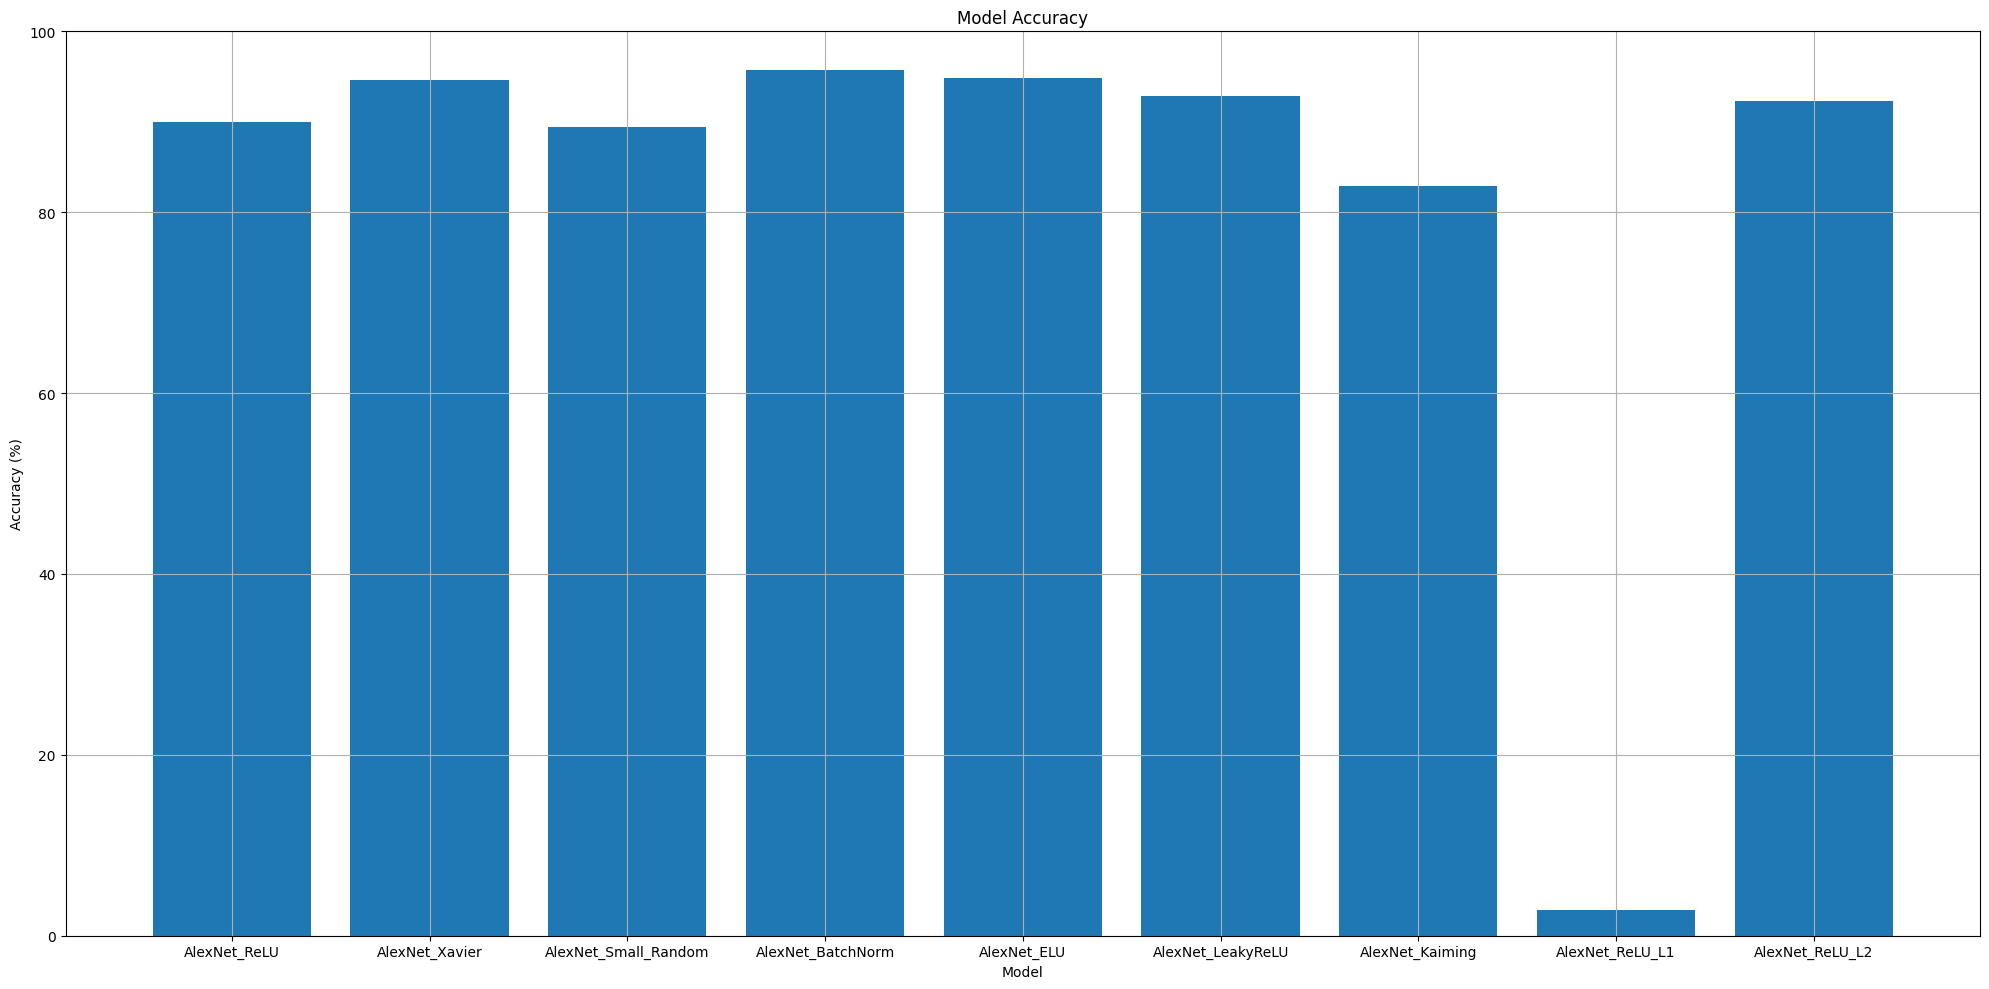

0 AlexNet_ReLU [60.0, 77.77777777777779, 100.0, 77.77777777777779, 90.0, 90.0, 100.0, 100.0, 77.77777777777779, 100.0, 90.0, 100.0, 100.0, 90.0, 100.0, 88.88888888888889, 100.0, 90.0, 55.55555555555556, 100.0, 90.0, 77.77777777777779, 90.0, 100.0, 100.0, 100.0, 100.0, 40.0, 100.0, 100.0, 100.0, 60.0, 90.0, 100.0, 100.0, 100.0]
1 AlexNet_Xavier [70.0, 77.77777777777779, 100.0, 88.88888888888889, 100.0, 100.0, 100.0, 100.0, 77.77777777777779, 80.0, 100.0, 100.0, 100.0, 100.0, 100.0, 77.77777777777779, 100.0, 100.0, 100.0, 90.0, 100.0, 88.88888888888889, 100.0, 100.0, 100.0, 100.0, 100.0, 70.0, 100.0, 90.0, 100.0, 100.0, 90.0, 100.0, 100.0, 100.0]
2 AlexNet_Small_Random [60.0, 77.77777777777779, 100.0, 88.88888888888889, 100.0, 100.0, 100.0, 100.0, 88.88888888888889, 60.0, 100.0, 100.0, 100.0, 90.0, 100.0, 77.77777777777779, 90.0, 100.0, 88.88888888888889, 90.0, 100.0, 88.88888888888889, 90.0, 100.0, 80.0, 100.0, 80.0, 50.0, 100.0, 100.0, 80.0, 100.0, 50.0, 90.0, 100.0, 100.0]
3 AlexNet_B

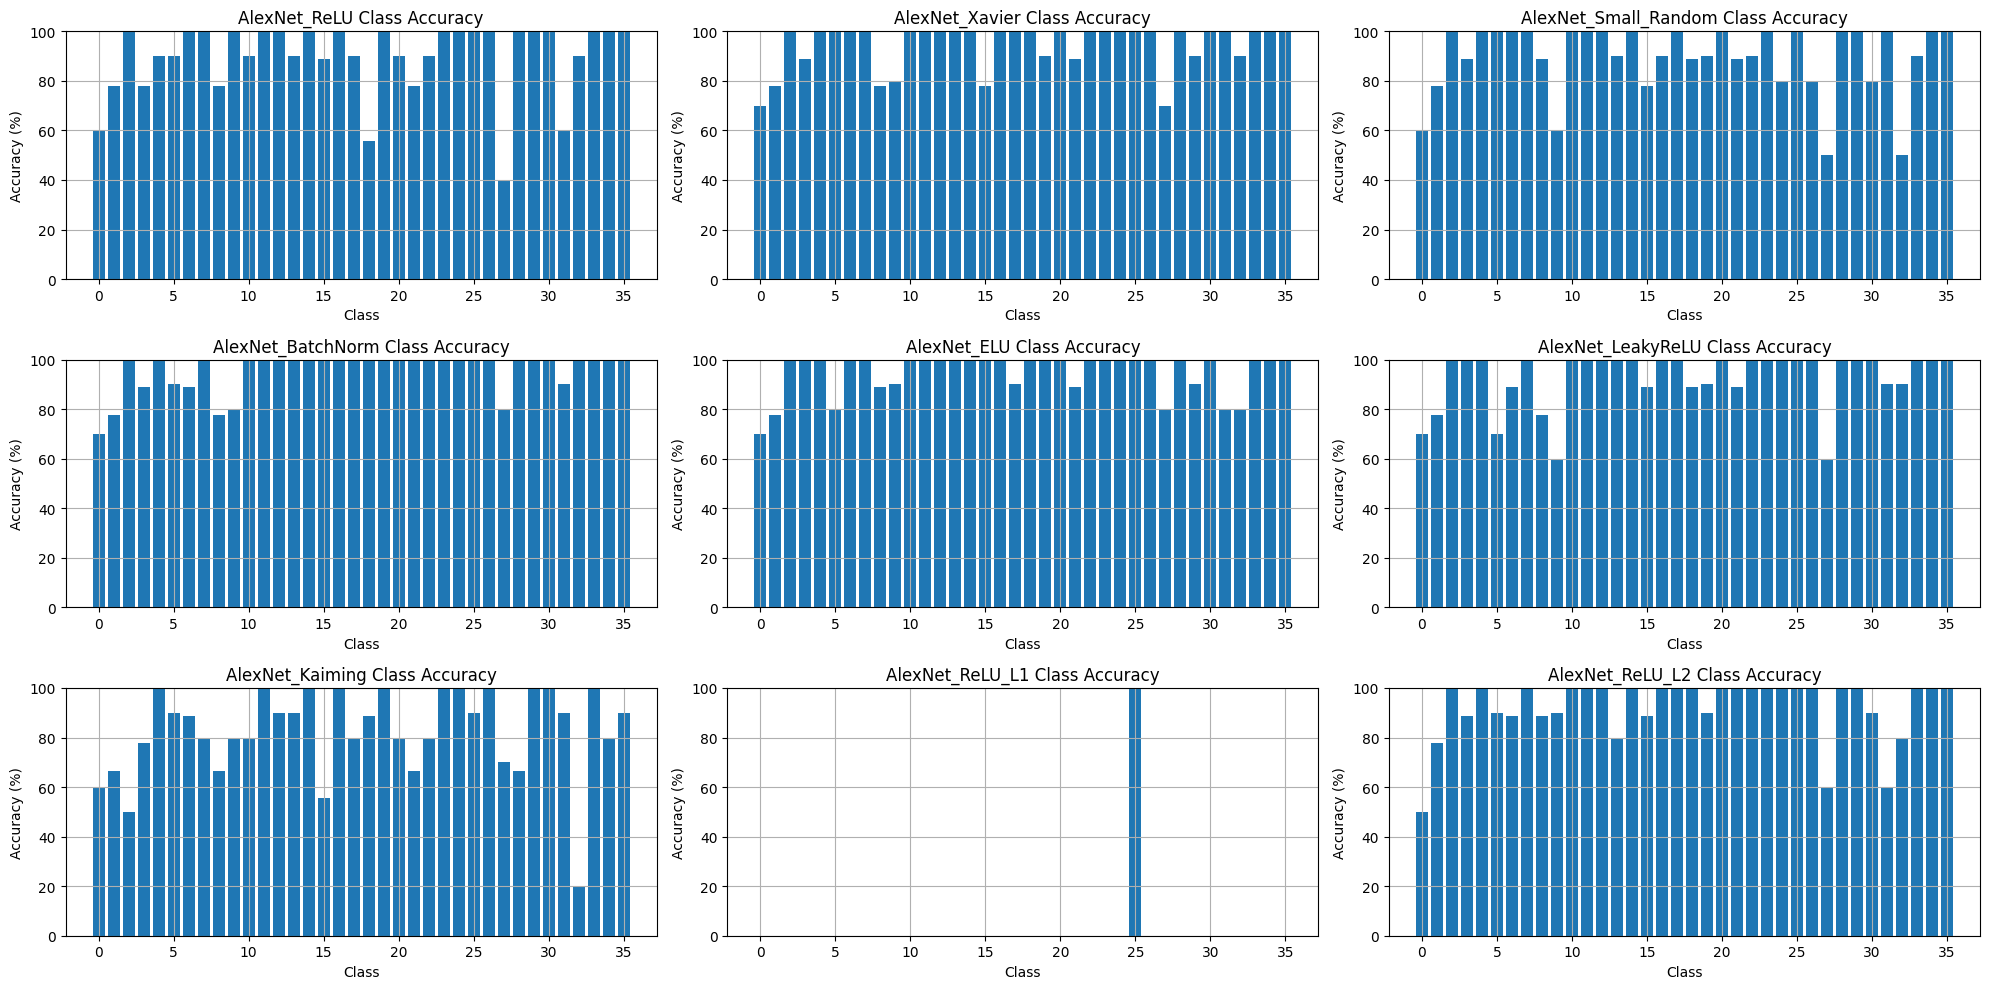

In [ ]:
import matplotlib.pyplot as plt

def histogram(models_accuracy, models_class_accuracy, model_names):
    fig, ax = plt.subplots(figsize=(20, 10))
    
    ax.bar(range(len(models_accuracy)), models_accuracy)
    ax.set_title('Model Accuracy')
    ax.set_ylim(0, 100)
    ax.set_ylabel('Accuracy (%)')
    ax.set_xlabel('Model')
    ax.set_xticks(range(len(models_accuracy)))
    ax.set_xticklabels(model_names)

    ax.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(3, 3, figsize=(20, 10))
    ax = ax.ravel()

    for i, (model_name, class_accuracy) in enumerate(models_class_accuracy.items()):
        print(i, model_name, class_accuracy)
        ax[i].bar(range(len(class_accuracy)), class_accuracy)
        ax[i].set_title(f'{model_name} Class Accuracy')
        ax[i].set_ylim(0, 100)
        ax[i].set_ylabel('Accuracy (%)')
        ax[i].set_xlabel('Class')
        ax[i].grid(True)

    plt.tight_layout()
    plt.show()

model_names = ["AlexNet_ReLU", "AlexNet_Xavier", "AlexNet_Small_Random", "AlexNet_BatchNorm", "AlexNet_ELU", "AlexNet_LeakyReLU", "AlexNet_Kaiming", "AlexNet_ReLU_L1", "AlexNet_ReLU_L2"]

histogram(models_accuracy, models_class_accuracy, model_names)


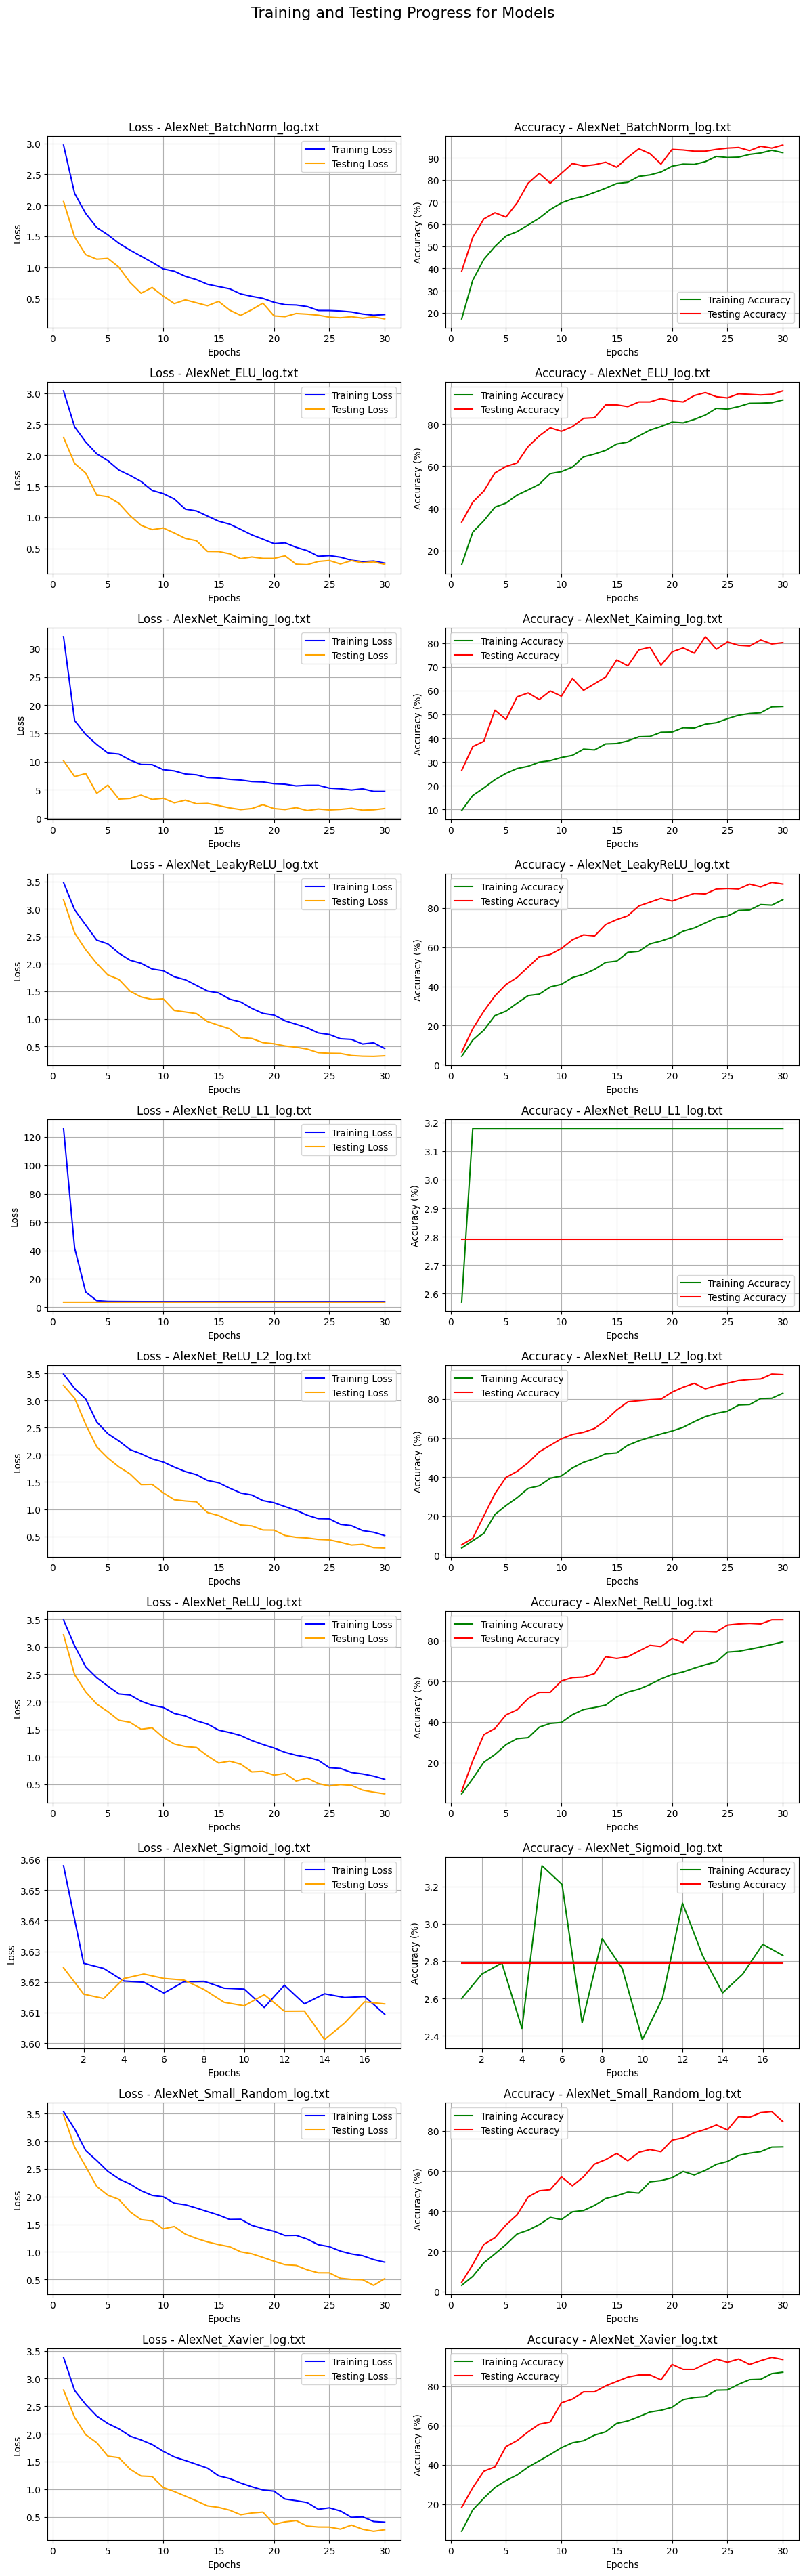

In [ ]:
import os
import re
import matplotlib.pyplot as plt

model_data = {}

log_files = [f for f in os.listdir() if f.endswith('.txt')]

epoch_pattern = re.compile(r"Epoch:\s*(\d+)")

train_loss_pattern = re.compile(r"Train(?:ing) Loss:\s*([\d.]+)")
train_acc_pattern = re.compile(r"Train(?:ing) Acc(?:uracy)?:\s*([\d.]+)%")
test_loss_pattern = re.compile(r"Test(?:ing) Loss:\s*([\d.]+)")
test_acc_pattern = re.compile(r"Test(?:ing) Acc(?:uracy)?:\s*([\d.]+)%")

for file in log_files:
    epochs, train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], [], []
    with open(file, 'r') as f:
        for line in f:
            # Extract information from each line
            if epoch_match := epoch_pattern.search(line):
                epochs.append(int(epoch_match.group(1)))
            if train_loss_match := train_loss_pattern.search(line):
                train_losses.append(float(train_loss_match.group(1)))
            if train_acc_match := train_acc_pattern.search(line):
                train_accuracies.append(float(train_acc_match.group(1)))
            if test_loss_match := test_loss_pattern.search(line):
                test_losses.append(float(test_loss_match.group(1)))
            if test_acc_match := test_acc_pattern.search(line):
                test_accuracies.append(float(test_acc_match.group(1)))
    
    # Store data in the dictionary
    model_data[file] = {
        "epochs": epochs,
        "train_losses": train_losses,
        "train_accuracies": train_accuracies,
        "test_losses": test_losses,
        "test_accuracies": test_accuracies
    }

num_models = len(model_data)
fig, axs = plt.subplots(10, 2, figsize=(12, 40))
fig.suptitle("Training and Testing Progress for Models", fontsize=16)

for i, (model_name, data) in enumerate(model_data.items()):
    axs[i, 0].plot(data['epochs'], data['train_losses'], label='Training Loss', color='blue')
    axs[i, 0].plot(data['epochs'], data['test_losses'], label='Testing Loss', color='orange')
    axs[i, 0].set_title(f'Loss - {model_name}')
    axs[i, 0].set_xlabel('Epochs')
    axs[i, 0].set_ylabel('Loss')
    axs[i, 0].legend()
    axs[i, 0].grid()
    
    axs[i, 1].plot(data['epochs'], data['train_accuracies'], label='Training Accuracy', color='green')
    axs[i, 1].plot(data['epochs'], data['test_accuracies'], label='Testing Accuracy', color='red')
    axs[i, 1].set_title(f'Accuracy - {model_name}')
    axs[i, 1].set_xlabel('Epochs')
    axs[i, 1].set_ylabel('Accuracy (%)')
    axs[i, 1].legend()
    axs[i, 1].grid()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()




## ReLU VS Sigmoid

ReLU outperformed the Sigmoid implementation. As you can see, the sigmoid version reached only 3% due-to <font color = 'red'> vanishing gradient issue </font> leading to "death" of some neurons. It means that gradient that goes deeper and deeper into network become smaller and smaller because of Sigmoid function and some neurons barely change.

### Xavier VS Small Random

There Xavier outperformed the Small random technique. The reason behind is that Xavier initialization starts with balanced weights, so learning can proceed effectively, helping avoid issues like gradients becoming too <font color='green'>large (exploding) or too small (vanishing)</font>, even after the first forward pass.

### Droup Out VS Batch Normalization

BN performed better than Droup Out. In my opinion, the random effect in the Droup out method is the key factor of its failure, whereas BN just normalized the inputs leading to more generalization and increased learning speed.